# **WGAN-GP** (**W**asserstein **GAN** with **G**radient **P**enalty)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import glob
from PIL import Image
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Conv2D
from keras.layers import Reshape, Conv2DTranspose, ReLU, LeakyReLU, Dropout, LayerNormalization
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.models import Sequential

print("TF version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

TF version: 2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## **1. Load and prepare the dataset**

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [2]:
(train_images, train_labels), (_, _) = mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images) / 255  # Normalize the images to [0, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256
noise_dim = 100 #100

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **2. Create the models**

### The Generator


In [3]:
import tensorflow_addons as tfa

c:\Users\aleja\anaconda3\envs\entorno1\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\aleja\anaconda3\envs\entorno1\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.


In [4]:
def make_generator_model(noise_dim: int) -> Sequential:
    model = Sequential(name="WGANGP_Generator_MNIST")

    # Proyección inicial del ruido a 7x7x128
    model.add(Dense(7 * 7 * 128, input_shape=(noise_dim,)))
    model.add(Reshape((7, 7, 128)))

    # Primera capa Conv2DTranspose → 14x14x64
    model.add(tfa.layers.SpectralNormalization(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same')))
    model.add(LayerNormalization())
    model.add(ReLU())

    # Segunda capa Conv2DTranspose → 28x28x32
    model.add(tfa.layers.SpectralNormalization(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same')))
    model.add(LayerNormalization())
    model.add(ReLU())

    # Capa final → Genera la imagen 28x28x1 (escala [-1, 1])
    model.add(tfa.layers.SpectralNormalization(Conv2DTranspose(1, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='tanh')))

    return model

generator = make_generator_model(noise_dim)
generator.summary()

Model: "WGANGP_Generator_MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 spectral_normalization (Spe  (None, 14, 14, 64)       73920     
 ctralNormalization)                                             
                                                                 
 layer_normalization (LayerN  (None, 14, 14, 64)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 14, 14, 64)        0         
                                                                 
 spectral_normalization_1 (S  (None, 28, 28,

Use the (as yet untrained) generator to create an image.

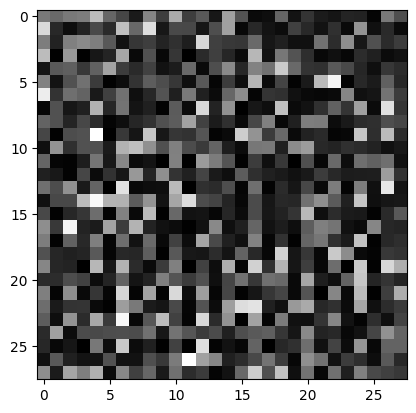

In [5]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

# normaliza los valores de la imagen antes de mostrarla
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

### The Discriminator

In [6]:
def make_discriminator_model() -> Sequential:
    model = Sequential(name="WGANGP_Discriminator_Model")
    
    # First convolution
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU(alpha=0.2))
    
    # Second convolution
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Third convolution
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dense(1))
    
    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "WGANGP_Discriminator_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [7]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.06618212]], shape=(1, 1), dtype=float32)


## **3. Define the loss and optimizers**

Define loss functions and optimizers for both models.


In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = BinaryCrossentropy()

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [9]:
def discriminator_loss(disc_real_output: tf.Tensor, disc_fake_output: tf.Tensor) -> tf.Tensor:
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = cross_entropy(tf.zeros_like(disc_fake_output), disc_fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [10]:
def generator_loss(disc_fake_output: tf.Tensor) -> tf.Tensor:
    return cross_entropy(tf.ones_like(disc_fake_output), disc_fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [11]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [12]:
checkpoint_dir = 'results_p2/WGAN_GP/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## **4. Define the training loop**


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [13]:
num_examples_to_generate = 16

# You will reuse this seed overtime 
# (so it's easier to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images: tf.Tensor) -> None:
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:     
        generated_images = generator(noise, training=True)
        
        disc_real_output = discriminator(images, training=True)
        disc_fake_outputs = discriminator(generated_images, training=True)

        gen_loss = generator_loss(disc_fake_outputs)
        disc_loss = discriminator_loss(disc_real_output, disc_fake_outputs)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

**Generate and save images**

In [14]:
def generate_and_save_images(model: Sequential, epoch: int, test_input: np.ndarray, show_figure: bool) -> None:
    # Notice 'training' is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions: np.ndarray = model(test_input, training=False)

    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap="gray")
        plt.axis("off")

    plt.savefig(f"results_p2/WGAN_GP/epochs/WGAN_GP_epoch_{epoch:03d}.png")
    if show_figure:
        plt.show()
    plt.close()

In [15]:
def train(dataset: tf.data.Dataset, epochs: int, trace: int) -> None:
    gen_loss_history = []
    disc_loss_history = []
    total_start = time.time()
    for epoch in range(epochs):
        start = time.time()

        gen_episode_loss = 0
        disc_episode_loss = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_episode_loss += gen_loss
            disc_episode_loss += disc_loss

        generate_and_save_images(model=generator, epoch=epoch, test_input=seed, show_figure=False)

        if epoch % trace == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f'Epoch {epoch}: {time.time()-start:.2f} secs, gen loss: {gen_episode_loss / BATCH_SIZE}, disc loss: {disc_episode_loss / BATCH_SIZE}')

        gen_loss_history.append(gen_episode_loss / BATCH_SIZE)
        disc_loss_history.append(disc_episode_loss / BATCH_SIZE)

    generate_and_save_images(model=generator, epoch=epochs, test_input=seed, show_figure=True)
    minutos, segundos = divmod(time.time()-total_start, 60)
    print(f"*******Total training time: {int(minutos)} mins y {segundos:.2f} secs*******")

    return gen_loss_history, disc_loss_history

## **5. Train the model**
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

Epoch 0: 3.84 secs, gen loss: 0.6683248281478882, disc loss: 1.1958348751068115
Epoch 2: 3.49 secs, gen loss: 0.8316508531570435, disc loss: 0.9483637809753418
Epoch 4: 3.51 secs, gen loss: 14.159652709960938, disc loss: 4.158370757068042e-06
Epoch 6: 3.43 secs, gen loss: 14.159652709960938, disc loss: 2.8467318315961165e-06
Epoch 8: 3.45 secs, gen loss: 14.159652709960938, disc loss: 2.028902599704452e-06
Epoch 10: 3.42 secs, gen loss: 14.159652709960938, disc loss: 1.5719579096185043e-06
Epoch 12: 3.42 secs, gen loss: 14.159652709960938, disc loss: 1.1806548627646407e-06
Epoch 14: 3.56 secs, gen loss: 14.159652709960938, disc loss: 7.531112942160689e-07
Epoch 16: 3.44 secs, gen loss: 14.159652709960938, disc loss: 6.046747671462072e-07
Epoch 18: 3.42 secs, gen loss: 14.159652709960938, disc loss: 4.155503461333865e-07
Epoch 20: 3.59 secs, gen loss: 14.159652709960938, disc loss: 1.810884242559041e-07
Epoch 22: 3.43 secs, gen loss: 14.159652709960938, disc loss: 0.0
Epoch 24: 3.45 sec

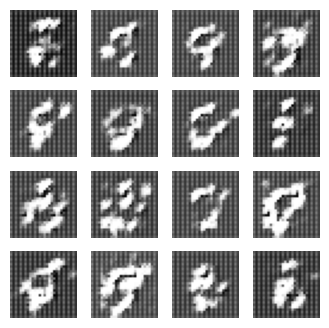

*******Total training time: 1 mins y 43.71 secs*******


In [18]:
EPOCHS = 30
trace = 2
gen_loss_history, disc_loss_history = train(train_dataset, EPOCHS, trace)

## **GAN losses history**

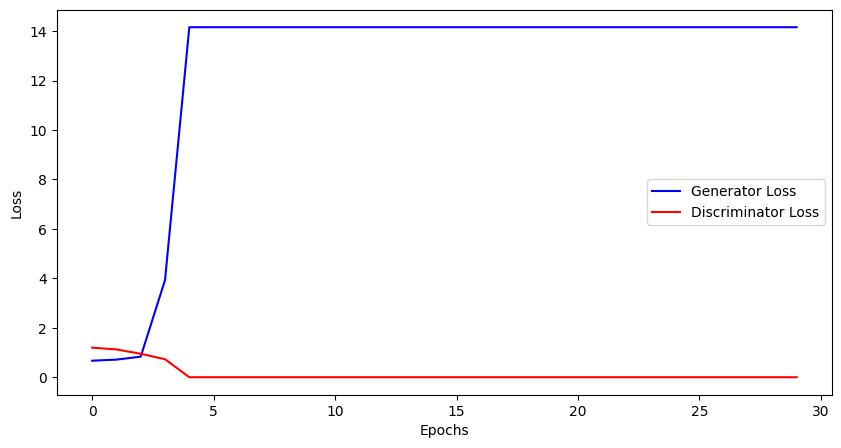

In [20]:
def plot_loss(gen_loss: list, disc_loss: list) -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss, label="Generator Loss", color="blue")
    plt.plot(disc_loss, label="Discriminator Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"results_p2/WGANGP_{EPOCHS}_loss_history.png")
    plt.show()

plot_loss(gen_loss_history, disc_loss_history)

**Restore the latest checkpoint.**

In [17]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## **6. Create a GIF**

In [ ]:
def create_gif_from_folder(folder_path: str, output_filename: str, duration: int) -> None:
    image_files = sorted(glob.glob(os.path.join(folder_path, "*.png")))
    frames = [Image.open(f) for f in image_files]
    frames[0].save(
        output_filename,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=1
    )

create_gif_from_folder(folder_path="results_p2/WGAN_GP/epochs", output_filename=f"results_p2/WGANGP_{EPOCHS}_results.gif", duration=30)

**Remove all folder images**

In [ ]:
import os
import glob

def remove_all_images(folder: str, extension: str = 'png') -> None:
    image_files = glob.glob(os.path.join(folder, f'*.{extension}'))
    for image_file in image_files:
        os.remove(image_file)
    print(f"Removed {len(image_files)} images from {folder}")

remove_all_images('results_p2/WGAN_GP/epochs')

Removed 501 images from results_p2/DC_GAN/epochs
